In [1]:
import os, sys 
import numpy as np
import matplotlib.pyplot as plt
os.chdir("/afs/cs.stanford.edu/u/daniter/gene/deeplearning/numpy/")
print os.getcwd()

/afs/cs.stanford.edu/u/daniter/gene/deeplearning/numpy


In [3]:
import glob
data = []
for f in glob.glob("*.npy"):
    l = np.load(f)
    if(l.shape[0] != 100):
        continue
    data.append(l)
data = np.array(data)
print data.shape

(1117, 100, 100)


In [4]:
data_norm = np.array(data, copy=True)  

#ub = np.max(data_norm)
#data_norm = data_norm/ub 

for i in range(data.shape[0]):
    ub = np.max(data[i])
    lb = np.min(data[i])
    rng  = ub - lb
    data_norm[i] = (data_norm[i] - lb)/rng

testIDX = np.unique(np.random.randint(low=0, high=data.shape[0], size=100))
trainIDX = list(set(range(data.shape[0])) - set(testIDX))

x_train = data_norm[trainIDX]
x_test = data_norm[testIDX]

In [5]:
x_train0 = np.array(x_train, copy=True)                              
x_test0 = np.array(x_test, copy=True)
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [6]:
# Convolutional Autoencoder
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

x_train = np.reshape(x_train0, (len(x_train0), 1, 100, 100))
x_test = np.reshape(x_test0, (len(x_test0), 1, 100, 100))

input_img = Input(shape=(1, 100, 100))

x = Convolution2D(50, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(25, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(25, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

# at this point the representation is (25, 12, 12) i.e. 128-dimensional

x = Convolution2D(25, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(25, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(50, 3, 3, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

autoencoder1 = Model(input_img, decoded)
autoencoder1.compile(optimizer='adadelta', loss='binary_crossentropy')

# this model maps an input to its encoded representation
encoder1 = Model(input=input_img, output=encoded)

Using Theano backend.


In [7]:
from keras.callbacks import TensorBoard
autoencoder1.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))
                # callbacks = [TensorBoard(log_dir='/tmp/autoencoder')]

Train on 1025 samples, validate on 92 samples
Epoch 1/50
1025/1025 [==============================] - 83s - loss: 0.6619 - val_loss: 0.6084
Epoch 2/50
1025/1025 [==============================] - 82s - loss: 0.5848 - val_loss: 0.5922
Epoch 3/50
1025/1025 [==============================] - 82s - loss: 0.5666 - val_loss: 0.6390
Epoch 4/50
1025/1025 [==============================] - 83s - loss: 0.5585 - val_loss: 0.5948
Epoch 5/50
1025/1025 [==============================] - 83s - loss: 0.5324 - val_loss: 0.5116
Epoch 6/50
1025/1025 [==============================] - 83s - loss: 0.5089 - val_loss: 0.4813
Epoch 7/50
1025/1025 [==============================] - 83s - loss: 0.4943 - val_loss: 0.4941
Epoch 8/50
1025/1025 [==============================] - 83s - loss: 0.4943 - val_loss: 0.4751
Epoch 9/50
1025/1025 [==============================] - 83s - loss: 0.4888 - val_loss: 0.4767
Epoch 10/50
1025/1025 [==============================] - 83s - loss: 0.4897 - val_loss: 0.4745
Epoch 11/50
1

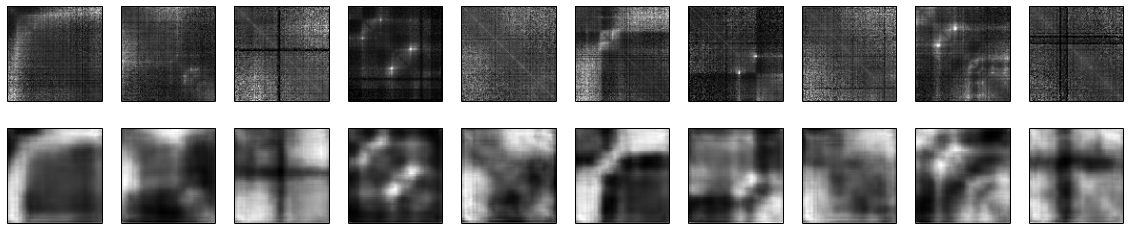

In [18]:
decoded_imgs = autoencoder1.predict(x_test)

import matplotlib.pyplot as plt
%matplotlib inline
n = 10  # how many windows we will display
IDX = np.unique(np.random.randint(low=0, high=x_test.shape[0], size=30))
plt.figure( figsize=(20, 4)) # figsize=(20, 4)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[IDX[i]].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[IDX[i]].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

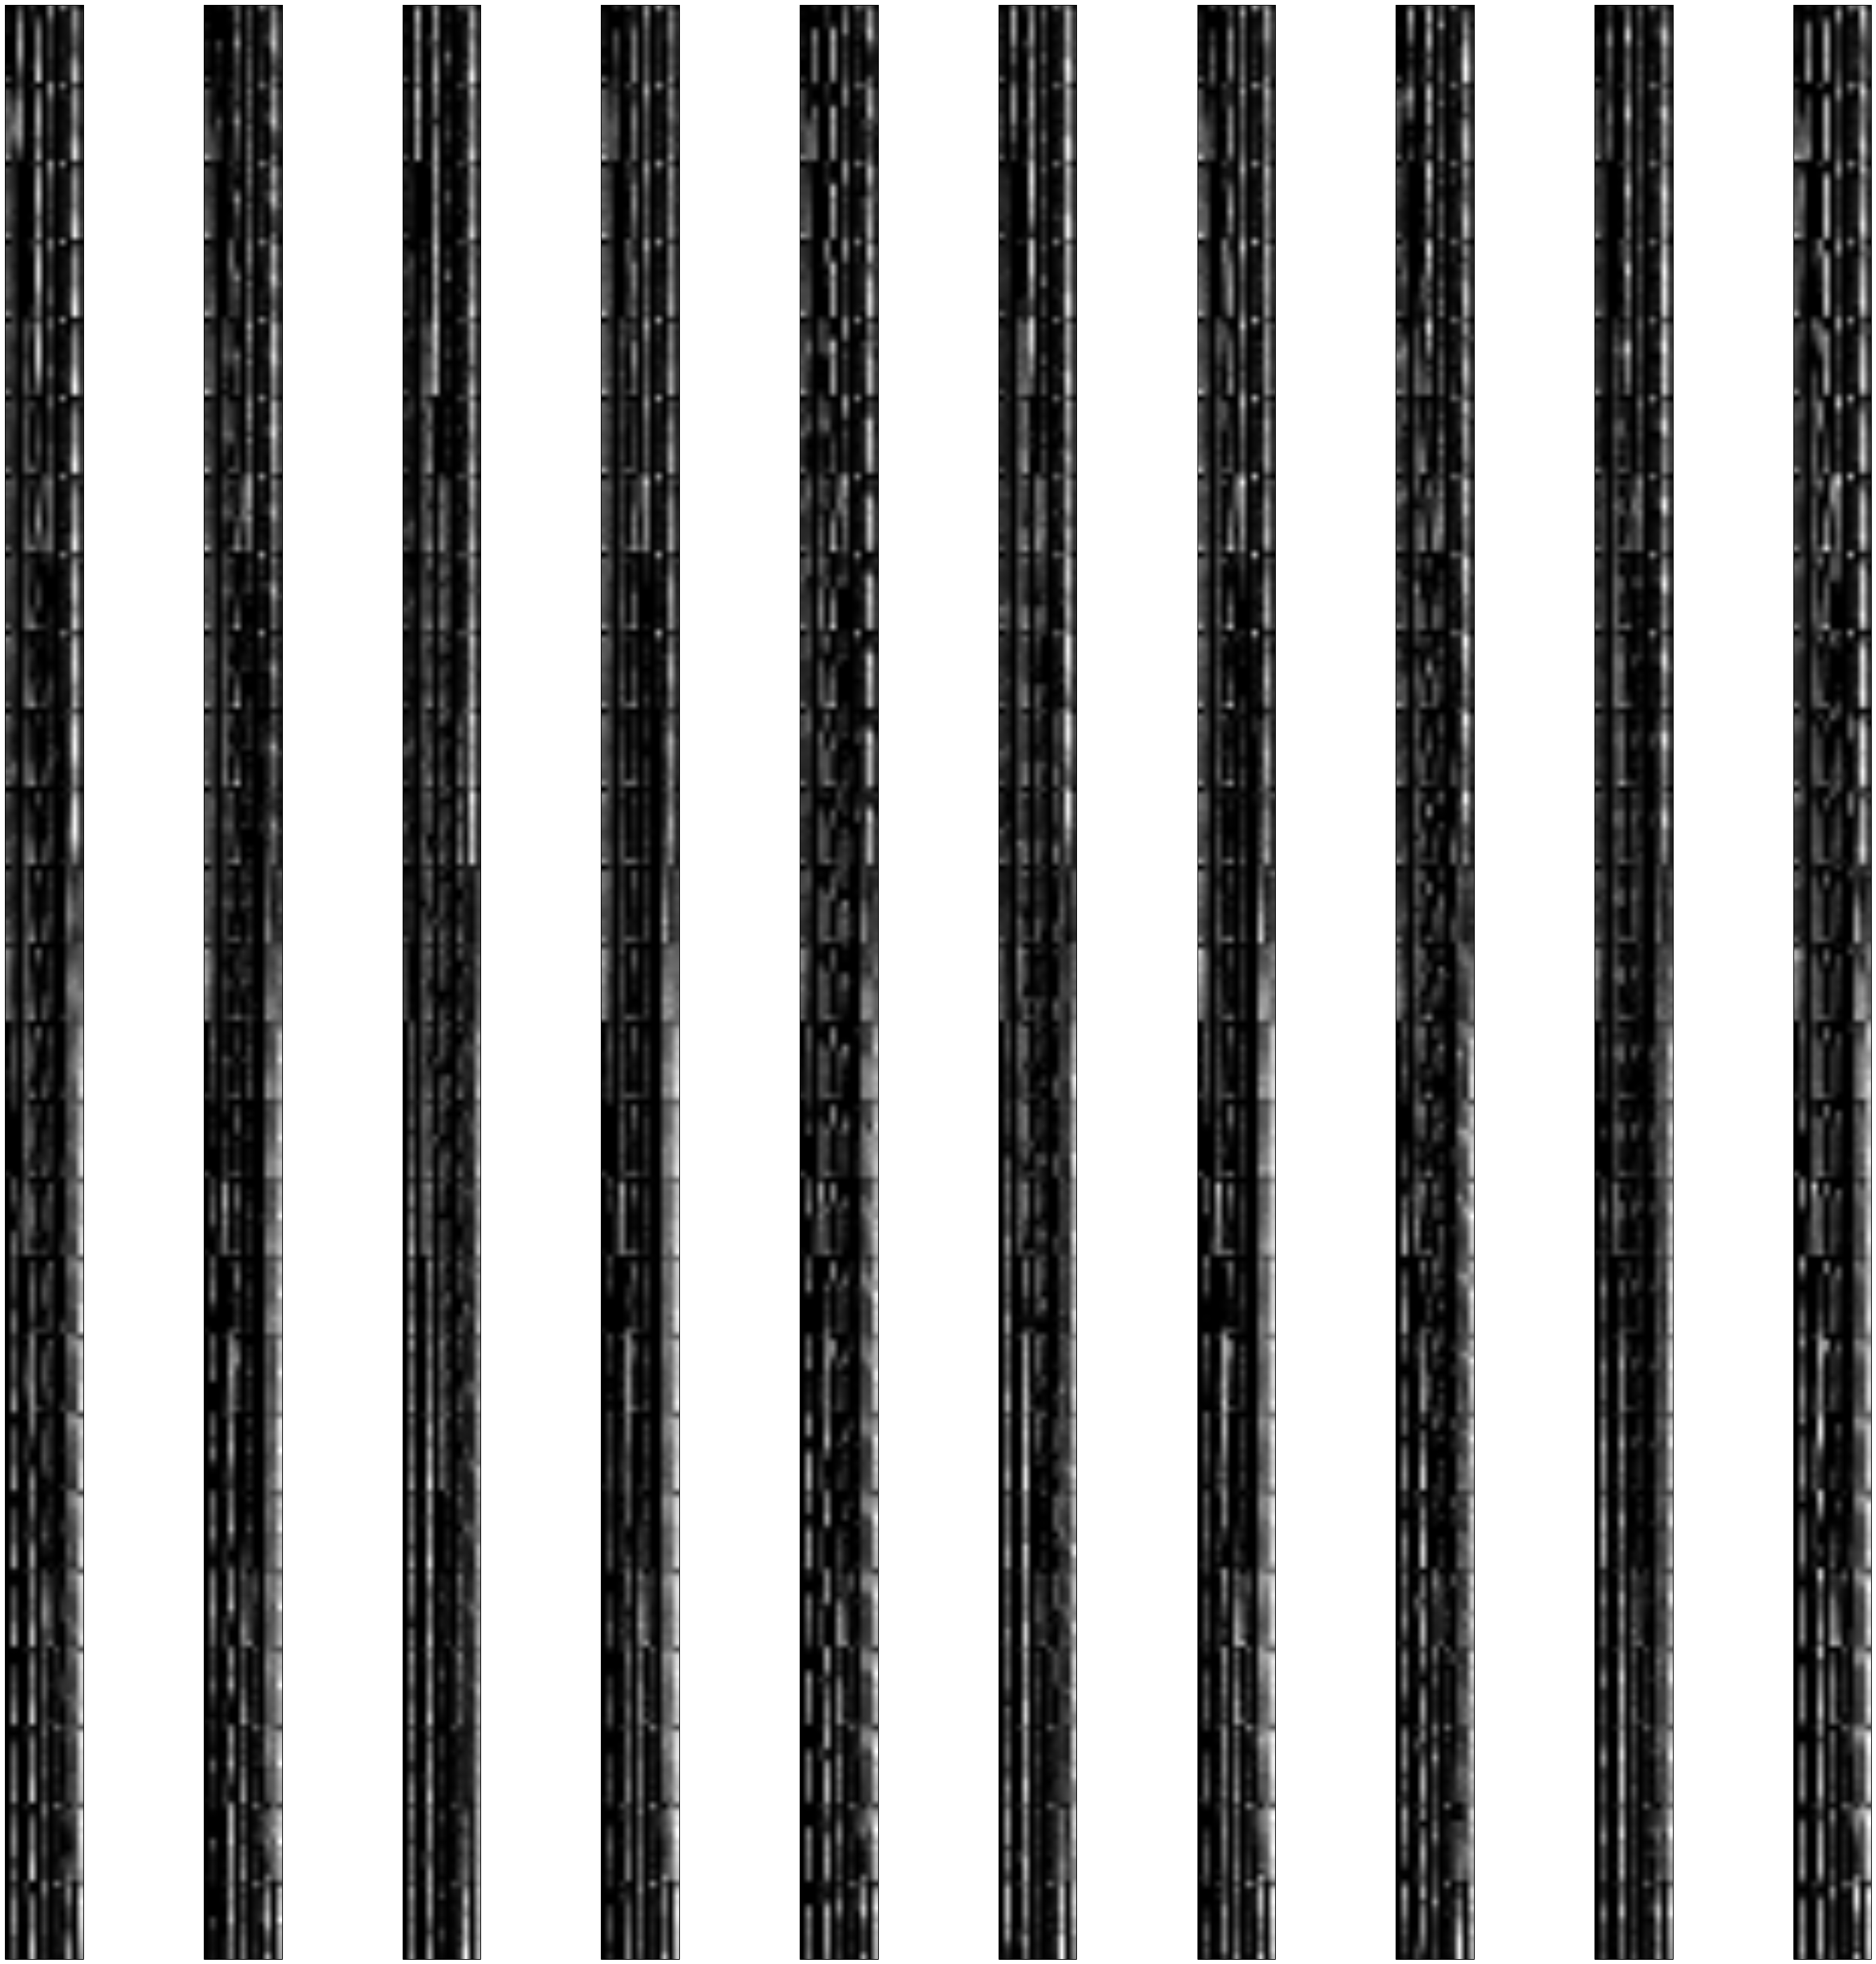

In [47]:
encoded_imgs = encoder1.predict(x_test)
n = 10
%matplotlib inline
plt.figure(figsize=(50, 50))
for i in range(n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[IDX[i]].reshape(13, 13 * 25).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
# Autoencoder as Denoising tool

from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard


x_train = np.reshape(x_train0, (len(x_train0), 1, 100, 100))
x_test = np.reshape(x_test0, (len(x_test0), 1, 100, 100))

input_img = Input(shape=(1, 100, 100))

x = Convolution2D(50, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(50, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

# at this point the representation is (50, 25, 25)

x = Convolution2D(50, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(50, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)


Using TensorFlow backend.


In [6]:
autoencoder.load_weights('my_model_weights.h5')

In [ ]:
autoencoder.fit(x_train, x_train,
                nb_epoch=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

#callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)]

In [8]:
decoded_imgs = autoencoder.predict(x_test)

[ 0  2 12 14 15 33 36 43 45 48 62 63 65 68 70 74 75 82 83 85 86 87 93 94]


[ 1  4  8 10 12 14 15 16 17 21 23 34 38 47 51 61 66 68 70 85 86 89 92 95]


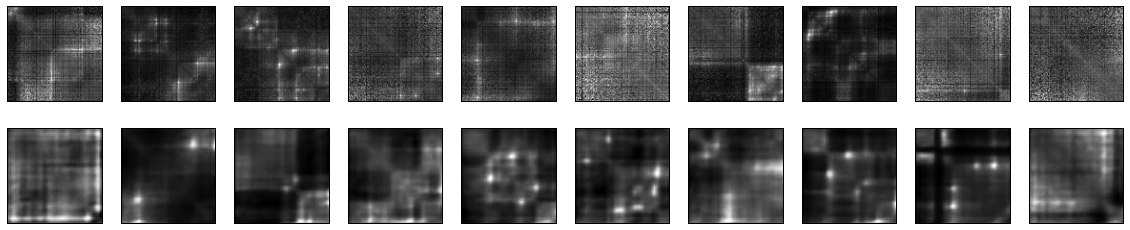

In [21]:
%matplotlib inline
n = 10  # how many windows we will display
IDX = np.unique(np.random.randint(low=0, high=x_test.shape[0], size=30))
print IDX
plt.figure( figsize=(20, 4)) # figsize=(20, 4)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[IDX[i]].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[IDX[i]].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
%matplotlib inline
encoded_imgs = encoder.predict(x_test)

ValueError: total size of new array must be unchanged

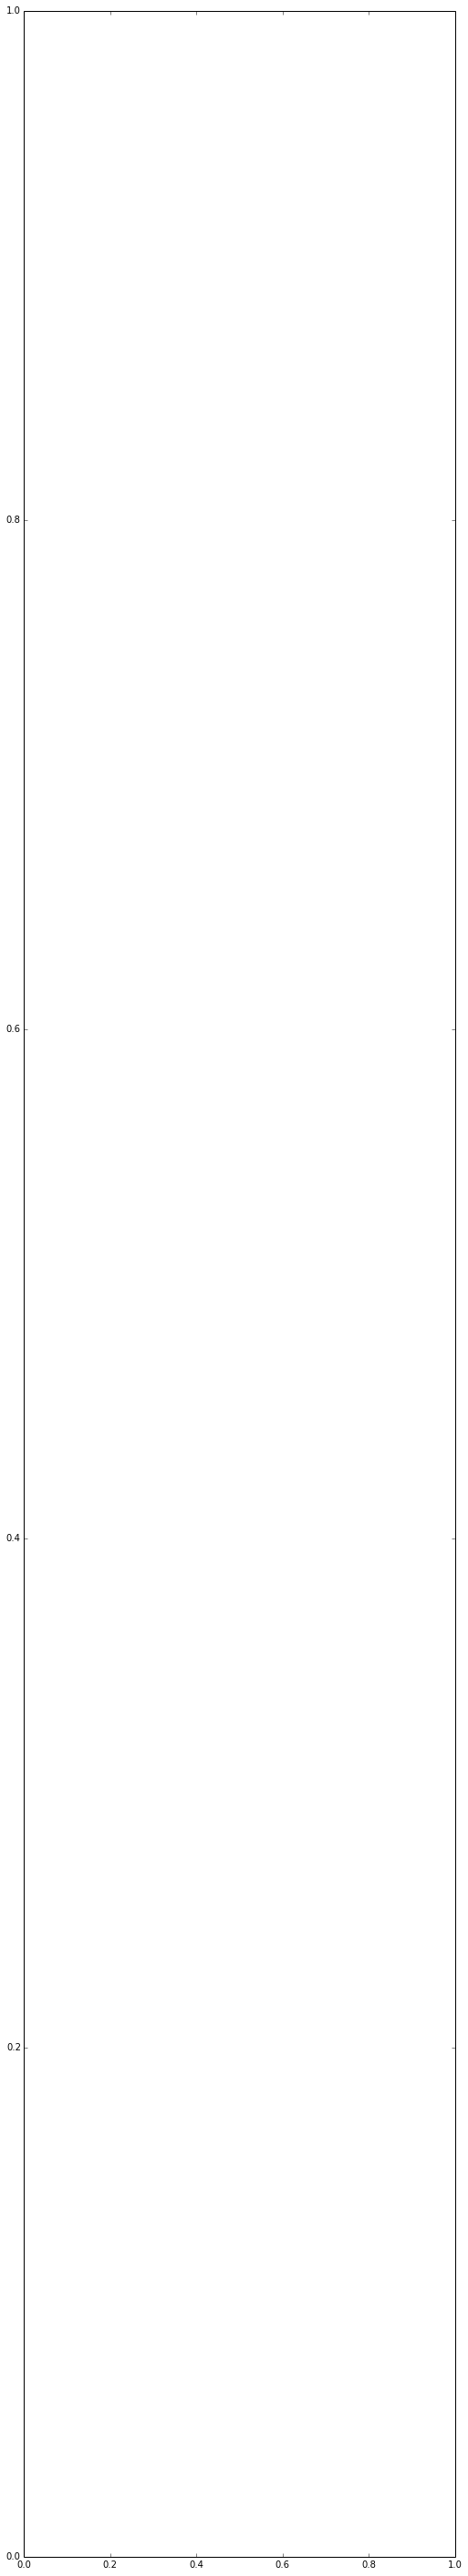

In [26]:
plt.figure(figsize=(100, 50))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[IDX[i]].reshape(25, 25 * 50).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

encoded_imgs[0].shape